<a href="https://colab.research.google.com/github/j-ranasinghe/Electricity-consumption-forecasting/blob/main/LSTM_cosnumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm as tqdm_notebook

In [40]:
cols = ["ACCOUNT_NO","DATE","SALES_TYPE","BILL","UNIT"]
df = pd.read_csv("/content/SAMPLE_DATA.csv", header=0, names=cols)
file = "/content/SAMPLE_DATA.csv"

In [41]:
df.head()

,ACCOUNT_NO,DATE,SALES_TYPE,BILL,UNIT
0,200005806,4/1/2022,C,2289.04,73
1,200009909,4/1/2022,C,120.00,1
2,200002506,4/1/2022,C,9448.27,241
3,200013110,4/1/2022,C,-8.85,11
4,200001802,4/1/2022,C,1539.76,68


In [42]:
df.shape #Check the shape of the dataset

(983, 5)

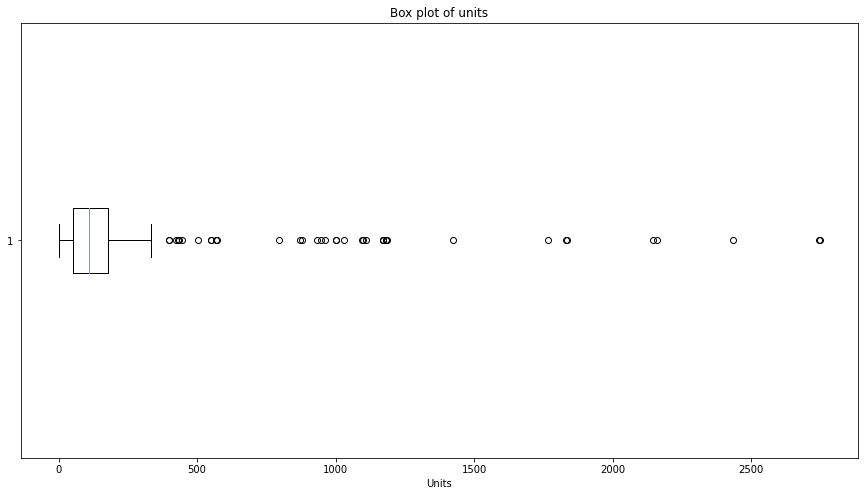

In [43]:
# Select the "units" column
units = df['UNIT']

# Create a new figure with desired size
fig = plt.figure(figsize=(15, 8))

# Create a box plot
plt.boxplot(units, vert=False)

# Add plot title and axis labels
plt.title('Box plot of units')
plt.xlabel('Units')
plt.show()


In [44]:
# Calculate the IQR for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identify any outliers as values that are more than 1.5 times the IQR away from the median
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)

# Drop rows containing outliers
df = df[~outliers]

<ipython-input-44-db77ef20ea4e>:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)


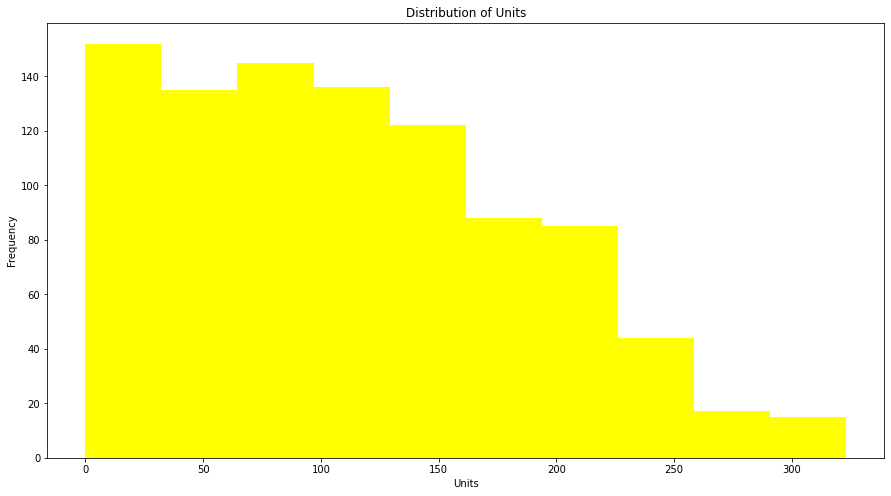

In [45]:
# Create a new figure with desired size
fig = plt.figure(figsize=(15, 8))

# Plot a histogram of the "units" column
plt.hist(df["UNIT"], color='yellow')

# Add axis labels and title
plt.xlabel("Units")
plt.ylabel("Frequency")
plt.title("Distribution of Units")

# Show the plot
plt.show()


In [46]:
df["UNIT"] = df["UNIT"].astype(float)
df["BILL"] = df["BILL"].astype(float)
df["ACCOUNT_NO"] = df["ACCOUNT_NO"].astype(float)

In [47]:
df["DATE"] = pd.to_datetime(df["DATE"])
df["MONTH"] = df["DATE"].dt.month
df["YEAR"] = df["DATE"].dt.year
df = df.sort_values("DATE").drop("DATE", axis=1)


In [48]:
df.dtypes

ACCOUNT_NO    float64
SALES_TYPE     object
BILL          float64
UNIT          float64
MONTH           int64
YEAR            int64
dtype: object

In [49]:
df.describe()

,ACCOUNT_NO,BILL,UNIT,MONTH,YEAR
count,9.390000e+02,939.000000,939.000000,939.000000,939.0
mean,2.000983e+08,3779.740618,113.331203,8.001065,2022.0
std,8.542600e+04,3338.645372,76.273174,2.588518,0.0
min,2.000018e+08,-8.850000,0.000000,4.000000,2022.0
25%,2.000350e+08,920.910000,51.000000,6.000000,2022.0
50%,2.000692e+08,2904.000000,103.000000,8.000000,2022.0
75%,2.001593e+08,5755.000000,166.500000,10.000000,2022.0
max,2.003006e+08,13938.000000,323.000000,12.000000,2022.0


In [50]:
df.isnull()

,ACCOUNT_NO,SALES_TYPE,BILL,UNIT,MONTH,YEAR
0,False,False,False,False,False,False
80,False,False,False,False,False,False
79,False,False,False,False,False,False
78,False,False,False,False,False,False
77,False,False,False,False,False,False
...,...,...,...,...,...,...
907,False,False,False,False,False,False
906,False,False,False,False,False,False
905,False,False,False,False,False,False
902,False,False,False,False,False,False


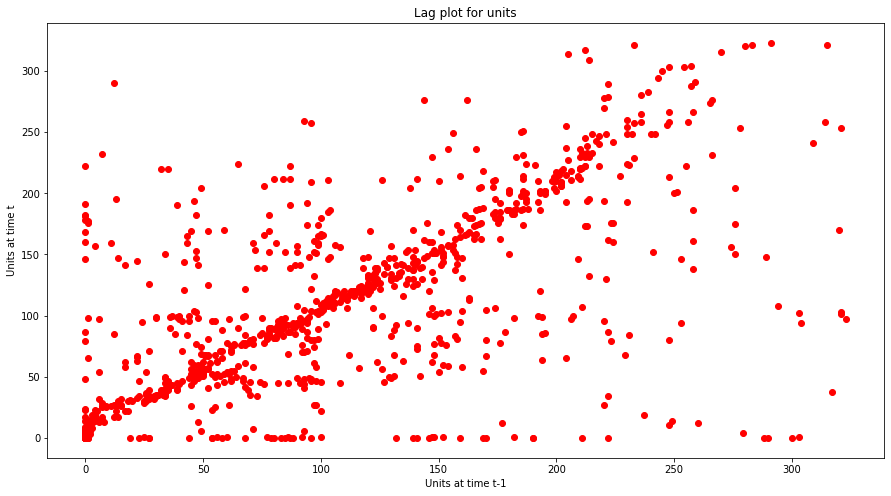

In [51]:
# Select only the "units" column
units = df['UNIT']
# Create a new figure with desired size
fig = plt.figure(figsize=(15, 8))
# Create a lag plot with a lag of 1
pd.plotting.lag_plot(units, lag=3, c = 'red')

# Add plot title and axis labels
plt.title('Lag plot for units')
plt.xlabel('Units at time t-1')
plt.ylabel('Units at time t')

plt.show()



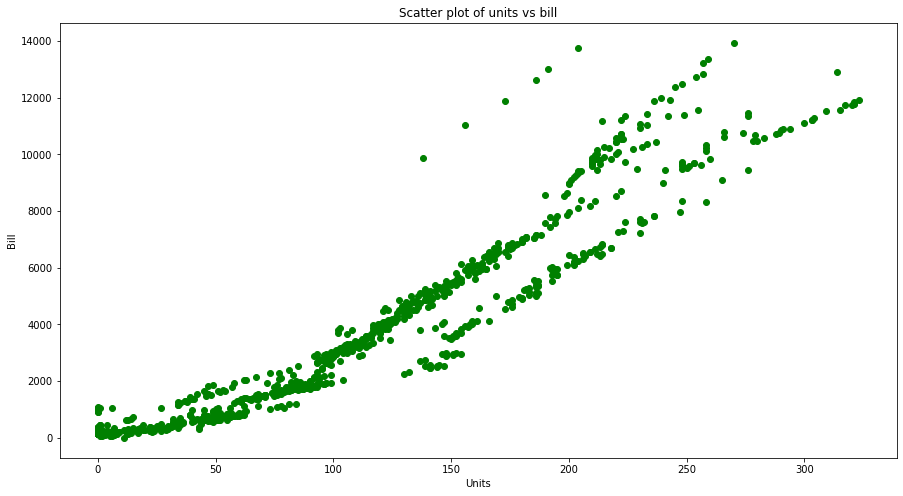

In [52]:
# Select the "units" and "bill" columns
units = df['UNIT']
bill = df['BILL']

# Create a new figure with desired size
fig = plt.figure(figsize=(15, 8))
# Create a scatter plot
plt.scatter(units, bill, c = 'green')

# Add plot title and axis labels
plt.title('Scatter plot of units vs bill')
plt.xlabel('Units')
plt.ylabel('Bill')
plt.show()


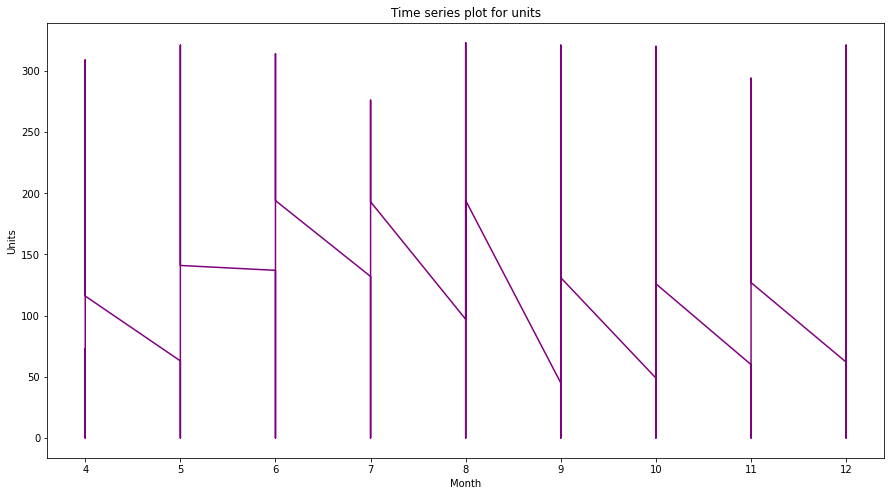

In [53]:
# Create a new DataFrame with "month" as the index and keep the original intact
df_indexed = df.set_index('MONTH', drop=False)

# Select only the "units" column from the new indexed DataFrame
units = df_indexed['UNIT']

# Create a new figure with desired size
fig = plt.figure(figsize=(15, 8))

# Create a time series plot
plt.plot(units, c='purple')

# Add plot title and axis labels
plt.title('Time series plot for units')
plt.xlabel('Month')
plt.ylabel('Units')
plt.show()



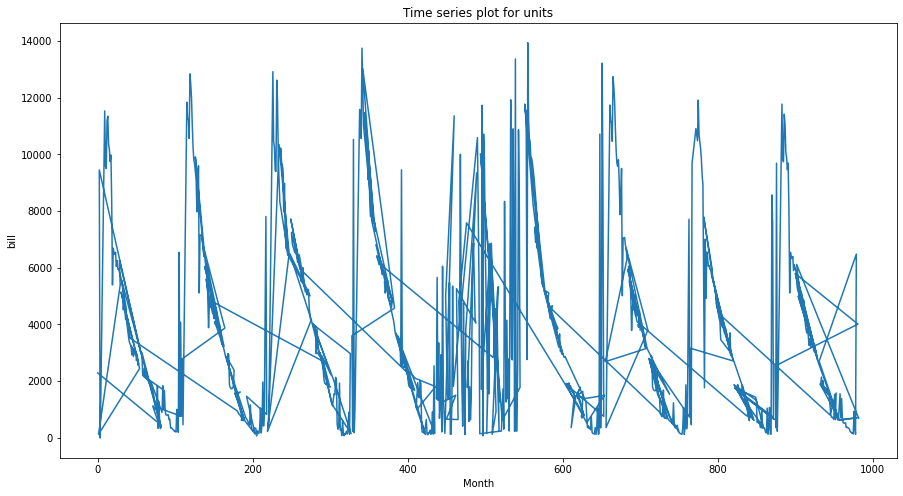

In [54]:
# Select only the "units" column
bill = df['BILL']

# Create a new figure with desired size
fig = plt.figure(figsize=(15, 8))

# Create a time series plot
plt.plot(bill)

# Add plot title and axis labels
plt.title('Time series plot for units')
plt.xlabel('Month')
plt.ylabel('bill')
plt.show()

In [55]:
# Extract the values for the "SALES_TYPE" column
Sales_type_data= df['SALES_TYPE'].values
# Create a LabelEncoder object
encoder = LabelEncoder()

# Fit the encoder to the sales type data
encoder.fit(Sales_type_data)

# Encode the location data
encoded_sales_type = encoder.transform(Sales_type_data)
df['SALES_TYPE'] =encoded_sales_type

In [56]:
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

In [57]:
df.head()

,ACCOUNT_NO,SALES_TYPE,BILL,UNIT,MONTH,YEAR
0,200005806.0,0,2289.04,73.0,4,2022
80,200041908.0,0,485.29,44.0,4,2022
79,200181410.0,0,1268.97,34.0,4,2022
78,200298307.0,0,330.00,34.0,4,2022
77,200197701.0,0,1845.00,49.0,4,2022


In [58]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [59]:
label_col_index = 3  # UNITS as label to predict
inputs_cols_indices = range(3)  # use ("ACCOUNT_NO","DATE","SALES_TYPE","BILL","UNIT") columns as features

# Define window_size period and split inputs/labels
window_size = 109

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

In [60]:
# Obtaining the scaler for the labels(usage data) so that output can be
# re-scaled to actual value during evaluation
label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
label_scalers[file] = label_sc


In [61]:
   # Move the window
inputs, labels = move_sliding_window(data,window_size,inputs_cols_indices=inputs_cols_indices,label_col_index=label_col_index, )

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
test_portion = int(0.1 * len(inputs))
if len(train_x) == 0:  # first iteration
    train_x = inputs[:-test_portion]
    train_y = labels[:-test_portion]
else:
    train_x = np.concatenate((train_x, inputs[:-test_portion]))
    train_y = np.concatenate((train_y, labels[:-test_portion]))
test_x[file] = inputs[-test_portion:]
test_y[file] = labels[-test_portion:]

(830, 109, 3) (830, 1)


In [63]:
from sklearn.model_selection import train_test_split
batch_size =16
# Split data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.2, random_state=42
)

# Create TensorDatasets and DataLoaders for training and validation sets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

val_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)


In [64]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

print(
    f"Validation Size: {val_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(val_x.shape[0]/batch_size)}"
)


Train Size: (477, 109, 3), Batch Size: 16, # of iterations per epoch: 29
Validation Size: (120, 109, 3), Batch Size: 16, # of iterations per epoch: 7


In [25]:
batch_size =16

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [65]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

Train Size: (477, 109, 3), Batch Size: 16, # of iterations per epoch: 29


In [66]:
# release some memory
del train_x, train_y

In [67]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

GPU is available


In [68]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [69]:
import matplotlib.pyplot as plt

def train(train_loader, val_loader, learn_rate, hidden_dim=256, n_layers=2, n_epochs=3, model_type="GRU", print_every=100):
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1

    # Instantiate the model
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []

    train_losses = []
    val_losses = []

    # Start training loop
    for epoch in range(1, n_epochs + 1):
        start_time = time.process_time()

        # Training loop
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])

            model.zero_grad()
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if counter % print_every == 0:
                print(
                    f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}"
                )

        current_time = time.process_time()
        train_losses.append(avg_loss / len(train_loader))
        print(f"Epoch {epoch}/{n_epochs} Done, Train Loss: {train_losses[-1]}")
        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for x, label in val_loader:
                h = model.init_hidden(batch_size)
                if model_type == "GRU":
                    h = h.data
                elif model_type == "LSTM":
                    h = tuple([e.data for e in h])

                out, h = model(x.to(device).float(), h)
                loss = criterion(out, label.to(device).float())
                val_loss += loss.item()

            val_losses.append(val_loss / len(val_loader))
            print(f"Validation Loss: {val_losses[-1]}")

        model.train()

    # Plot the training and validation losses
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model


Starting Training of LSTM model
Epoch 1/100 Done, Train Loss: 0.10654026655287578
Time Elapsed for Epoch: 0.8397290220000002 seconds
Validation Loss: 0.08746622715677534
Epoch 2/100 Done, Train Loss: 0.05995882418135117
Time Elapsed for Epoch: 0.8242327640000013 seconds
Validation Loss: 0.06720162236264773
Epoch 3/100 Done, Train Loss: 0.055715128972098744
Time Elapsed for Epoch: 0.8004411240000024 seconds
Validation Loss: 0.05907576531171799
Epoch 4/100 Done, Train Loss: 0.054880296490315734
Time Elapsed for Epoch: 0.8032585469999987 seconds
Validation Loss: 0.06225971505045891
Epoch 5/100 Done, Train Loss: 0.053457733307932985
Time Elapsed for Epoch: 0.8046515509999921 seconds
Validation Loss: 0.06540772851024355
Epoch 6/100 Done, Train Loss: 0.049298797894654606
Time Elapsed for Epoch: 0.8026194730000071 seconds
Validation Loss: 0.05161450217877116
Epoch 7/100 Done, Train Loss: 0.049521101638674736
Time Elapsed for Epoch: 0.8039401749999939 seconds
Validation Loss: 0.072265758046082

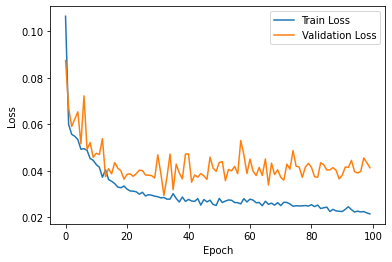

Total Training Time: 0 seconds


In [82]:
n_hidden = 356
n_layers = 4
n_epochs = 100
print_every = 50
lr = 0.0001
lstm_model = train(
    train_loader,
    val_loader=val_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
)


In [83]:
torch.save(lstm_model.state_dict(), "/content/model/lstm_model.pt")

In [84]:
hidden_dim = 356
input_dim = 3
output_dim = 1
n_layers = 4
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("/content/model/lstm_model.pt"))

<All keys matched successfully>

In [85]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(3, 356, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=356, out_features=1, bias=True)
  (relu): ReLU()
)

In [86]:
def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
    )
    return sMAPE

In [87]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # get data of test data for each state
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        h = model.init_hidden(inputs.shape[0])

        # predict outputs
        with torch.no_grad():
            out, h = model(inputs.to(device).float(), h)

        outputs.append(
            label_scalers[file]
            .inverse_transform(out.cpu().detach().numpy())
            .reshape(-1)
        )

        targets.append(
            label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)
        )

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    # list of of targets/outputs for each state
    return outputs, targets, sMAPE

In [88]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 0.041758763999979465
sMAPE: 9.624%


In [89]:
len(
    lstm_outputs
)  # list of predicted output file for each state (each element has a 1d array for that state)

1

In [91]:
states_list = list(test_x.keys())

In [92]:
states_list

['/content/SAMPLE_DATA.csv']

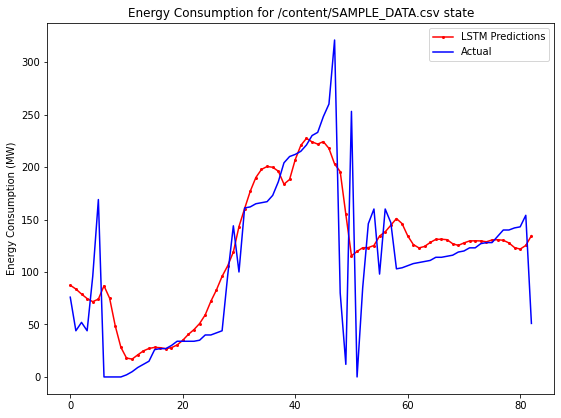

In [95]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(
    lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2
)
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

